Renderizando frame 1/1 (100.0%)


┌ Info: Saved animation to c:\Users\giost\OneDrive\Escritorio\Pro-Fac\LENTES GRAVITATORIOS A PARTIR DE RAY TRAICING GEODECICO\Precentacion\agujero_negro_RK4.gif
└ @ Plots C:\Users\giost\.julia\packages\Plots\bpxfB\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\giost\\OneDrive\\Escritorio\\Pro-Fac\\LENTES GRAVITATORIOS A PARTIR DE RAY TRAICING GEODECICO\\Precentacion\\agujero_negro_RK4.gif")
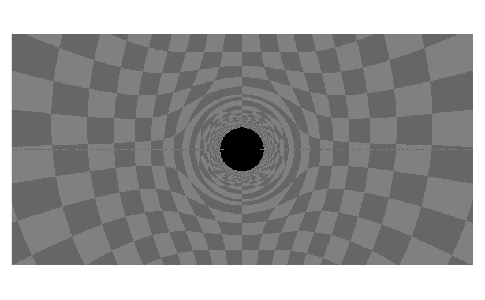

In [ ]:
using Plots
using LinearAlgebra
using Colors
using Printf

gr() 

# --- 1. PARÁMETROS GLOBALES ---
const ALTO = 400
const ANCHO = 800
const RS_VAL = 1.0 
const MAX_STEPS = 500 
const DT = 0.05     

# --- 2. TU CÓDIGO DE FÍSICA (Modificado mínimamente para integración) ---

mutable struct Ray
    vel::Float64
    Position::Vector{Float64}
    direc::Vector{Float64}
    r::Float64
    θ::Float64
    ϕ::Float64
    dr::Float64
    dθ::Float64
    dϕ::Float64
end

function crear_ray(c, Position, direc)
    x, y, z = Position
    r = sqrt(x^2 + y^2 + z^2)

    z_clamped = clamp(z/r, -1+eps(), 1-eps())
    θ = acos(z_clamped)
    ϕ = atan(y, x)
    

    dr = (direc[1]*x + direc[2]*y + direc[3]*z) / r
    denom_theta = (r^2 * sqrt(1 - z_clamped^2))
    dθ = (z*dr - r*direc[3]) / denom_theta
    dϕ = (-direc[1]*y + direc[2]*x) / (x^2 + y^2)
    
    return Ray(c, Position, direc, r, θ, ϕ, dr, dθ, dϕ)
end

function normalized(direc)
    n = norm(direc)
    return [direc[1]/n, direc[2]/n, direc[3]/n]
end





function geodesic_equations(ray::Ray, rs)
    r = ray.r
    θ = ray.θ
    ϕ = ray.ϕ
    dr = ray.dr
    dθ = ray.dθ
    dϕ = ray.dϕ
    
    
    if r > rs
        f = 1.0 - rs/r
        
        # Ecuaciones corregidas para métrica de Schwarzschild
        d2r = (rs/(2*r^2)) * (1 - rs/r)^(-1) * dr^2 + 
              r * (1 - rs/r) * (dθ^2 + sin(θ)^2 * dϕ^2) -
              (rs/(2*r^2)) * (1 - rs/r)
        
        d2θ = -2.0 * dr * dθ / r + sin(θ) * cos(θ) * dϕ^2
        
        d2ϕ = -2.0 * dr * dϕ / r - 2.0 * cos(θ) * dθ * dϕ / sin(θ)
    else
        d2r = -rs / (2.0 * r^2)
        d2θ = 0.0
        d2ϕ = 0.0
    end
    
    return d2r, d2θ, d2ϕ
end
function geodesic_equations_med(r ,θ ,ϕ ,dr ,dθ ,dϕ , rs)

    if r > rs
        f = 1.0 - rs/r
        
        # Ecuaciones corregidas para métrica de Schwarzschild
        d2r = (rs/(2*r^2)) * (1 - rs/r)^(-1) * dr^2 + 
              r * (1 - rs/r) * (dθ^2 + sin(θ)^2 * dϕ^2) -
              (rs/(2*r^2)) * (1 - rs/r)
        
        d2θ = -2.0 * dr * dθ / r + sin(θ) * cos(θ) * dϕ^2
        
        d2ϕ = -2.0 * dr * dϕ / r - 2.0 * cos(θ) * dθ * dϕ / sin(θ)
    else
        d2r = -rs / (2.0 * r^2)
        d2θ = 0.0
        d2ϕ = 0.0
    end
    
    return d2r, d2θ, d2ϕ
end
function step!(ray::Ray, dt, R_s)

    # PASO 1: k1
    d2r₁, d2θ₁, d2ϕ₁ = geodesic_equations(ray, R_s)

    kr₁ = dt * ray.dr
    kdr₁ = dt * d2r₁
    
    kθ₁ = dt * ray.dθ
    kdθ₁ = dt * d2θ₁

    kϕ₁ = dt * ray.dϕ
    kdϕ₁ = dt * d2ϕ₁
    
    # PASO 2: k2 (punto medio con k1)
    mr₁ = ray.r + kr₁/2
    mdr₁ = ray.dr + kdr₁/2

    mθ₁ = ray.θ + kθ₁/2
    mdθ₁ = ray.dθ + kdθ₁/2

    mϕ₁ = ray.ϕ + kϕ₁/2
    mdϕ₁ = ray.dϕ + kdϕ₁/2

    d2r₂, d2θ₂, d2ϕ₂ = geodesic_equations_med(mr₁, mθ₁, mϕ₁, mdr₁, mdθ₁, mdϕ₁, R_s)
    
    kr₂ = dt * mdr₁ 
    kdr₂ = dt * d2r₂

    kθ₂ = dt * mdθ₁ 
    kdθ₂ = dt * d2θ₂

    kϕ₂ = dt * mdϕ₁  
    kdϕ₂ = dt * d2ϕ₂
    
    # PASO 3: k3 (punto medio con k2)
    mr₂ = ray.r + kr₂/2
    mdr₂ = ray.dr + kdr₂/2

    mθ₂ = ray.θ + kθ₂/2
    mdθ₂ = ray.dθ + kdθ₂/2

    mϕ₂ = ray.ϕ + kϕ₂/2
    mdϕ₂ = ray.dϕ + kdϕ₂/2

    d2r₃, d2θ₃, d2ϕ₃ = geodesic_equations_med(mr₂, mθ₂, mϕ₂, mdr₂, mdθ₂, mdϕ₂, R_s)
    
    kr₃ = dt * mdr₂  
    kdr₃ = dt * d2r₃

    kθ₃ = dt * mdθ₂  
    kdθ₃ = dt * d2θ₃

    kϕ₃ = dt * mdϕ₂  
    kdϕ₃ = dt * d2ϕ₃
    
    # PASO 4: k4 (punto final con k3)
    mr₃ = ray.r + kr₃
    mdr₃ = ray.dr + kdr₃

    mθ₃ = ray.θ + kθ₃
    mdθ₃ = ray.dθ + kdθ₃

    mϕ₃ = ray.ϕ + kϕ₃
    mdϕ₃ = ray.dϕ + kdϕ₃

    d2r₄, d2θ₄, d2ϕ₄ = geodesic_equations_med(mr₃, mθ₃, mϕ₃, mdr₃, mdθ₃, mdϕ₃, R_s)  # ← CORRECCIÓN: d2r₄, d2θ₄, d2ϕ₄

    kr₄ = dt * mdr₃  
    kdr₄ = dt * d2r₄ 

    kθ₄ = dt * mdθ₃  
    kdθ₄ = dt * d2θ₄

    kϕ₄ = dt * mdϕ₃  
    kdϕ₄ = dt * d2ϕ₄  
    
    # Combinación ponderada - ACTUALIZAR
    ray.r += (kr₁ + 2*kr₂ + 2*kr₃ + kr₄) / 6
    ray.dr += (kdr₁ + 2*kdr₂ + 2*kdr₃ + kdr₄) / 6

    ray.θ += (kθ₁ + 2*kθ₂ + 2*kθ₃ + kθ₄) / 6
    ray.dθ += (kdθ₁ + 2*kdθ₂ + 2*kdθ₃ + kdθ₄) / 6
    
    ray.ϕ += (kϕ₁ + 2*kϕ₂ + 2*kϕ₃ + kϕ₄) / 6
    ray.dϕ += (kdϕ₁ + 2*kdϕ₂ + 2*kdϕ₃ + kdϕ₄) / 6
    
    # Conversión a coordenadas cartesianas y verificación
    x = ray.r * sin(ray.θ) * cos(ray.ϕ)
    y = ray.r * sin(ray.θ) * sin(ray.ϕ)
    z = ray.r * cos(ray.θ)
    
    ray.Position = [x, y, z]
    
    if abs(x) > 20.0 || abs(y) > 20.0 || abs(z) > 20.0 || ray.r <= R_s
        return true # Terminó (escapó o cayó)
    end
    
    return false # Sigue vivo
end














# --- 3. LÓGICA DE ESCENA Y COLISIONES ---
struct Black_houl
    rs::Float64
end

struct Scene
    disk_r_inner::Float64
    disk_r_outer::Float64
    planet_pos::Vector{Float64}
    planet_radius::Float64
end

function check_collision(pos::Vector{Float64}, scene::Scene,Bh::Black_houl)
    x, y, z = pos
    r = sqrt(x^2 + y^2 + z^2)

    # 1. Agujero Negro
    if r <= Bh.rs *1.2
        return RGB(0.0, 0.0, 0.0) 
    end

    # 2. Disco de Acreción 

    if abs(y) < 0.2
        r_cyl = sqrt(x^2 + z^2)
        if r_cyl > scene.disk_r_inner && r_cyl < scene.disk_r_outer
            
            heat = 1.0 - (r_cyl - scene.disk_r_inner) / (scene.disk_r_outer - scene.disk_r_inner)
            return RGB(1.0, 0.4 + 0.6*heat, 0.1*heat)
        end
    end

    # 3. Planeta Azul
    dist_planet = norm(pos - scene.planet_pos)
    if dist_planet < scene.planet_radius
        return RGB(0.0, 0.2, 1.0) 
    end

    return nothing 
end

# --- 4. RENDERIZADO RELATIVISTA ---

function trace_relativistic_ray(ray::Ray, scene::Scene, black::Black_houl)

    for step in 1:MAX_STEPS
        
        # 1. Verificar colisiones
        color = check_collision(ray.Position, scene,black)
        if color !== nothing
            return color
        end
        
        # 2. Avanzar
        finished = step!(ray, DT, black.rs)
        
        if finished

            if ray.r <= black.rs  #Agujero Negro
                return RGB(0.0, 0.0, 0.0) 

            else #Fondo
                return RGB(0.05, 0.05, 0.1) 

            end
        end
    end
    return RGB(0.05, 0.05, 0.1)
end

function render_frame(cam_pos, lookat, scene,black)
    W = ANCHO; H = ALTO # Resolución balanceada
    img = Array{RGB}(undef, H, W)
    
    vup = [0.0, 1.0, 0.0]
    fov = 60.0
    scale = tan(deg2rad(fov)*0.5)
    aspect = W/H
    
    w = normalized(cam_pos - lookat)
    u = normalized(cross(vup, w))
    v = cross(w, u)
    
    Threads.@threads for j in 1:H
        ndc_y = (1.0 - 2.0*(j+0.5)/H) * scale
        for i in 1:W
            ndc_x = (2.0*(i+0.5)/W - 1.0) * aspect * scale
            dir = normalized(ndc_x*u + ndc_y*v - w)
            ray = crear_ray(1.0,cam_pos, dir)
            img[j, i] = trace_relativistic_ray(ray, scene, black)
        end
    end
    return img
end
# --- 5. ANIMACIÓN ---

black=Black_houl(RS_VAL)

mi_escena = Scene(2.5, 6.0,[10.5, 0.0, 0.0],2.0)

TOTAL_FRAMES = 1

anim = @animate for k in 1:TOTAL_FRAMES

    angle = 2π * (k / TOTAL_FRAMES)
    
    cam_r = 100.0
    cam_x = 15 #cam_r * cos(angle)
    cam_z = 0 #cam_r * sin(angle)
    cam_y =1
    mi_escena = Scene(2.5, 6.0,[cam_r * cos(angle), 0.0, cam_r * sin(angle)],2.0)
    cam_pos = [cam_x ,cam_y,cam_z]
    lookat = [0.0, 0.0, 0.0]
    
    @printf("Renderizando frame %d/%d (%.1f%%)\n", k, TOTAL_FRAMES, 100*k/TOTAL_FRAMES)
    
    img = render_frame(cam_pos, lookat, mi_escena,black)
    phi=(1+sqrt(5))/2
    plot(img, seriestype=:image, axis=nothing, border=:none, size=(300*(phi), 300))
end

gif(anim, "agujero_negro_RK4.gif", fps=15)